In [67]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive, Layout
import ipywidgets as widgets
import scipy.stats as ss
import json
%matplotlib notebook
import parmap
from functools import partial
import multiprocessing 
import plotly
import susipop as sp
import pylab
from tqdm import tqdm
import warnings
from scipy import signal
warnings.filterwarnings('ignore')

In [68]:
# class autocorrelations():
#     def __init__(self,correl_type):
#         self.correl_type = correl_type
#     def calc_correlation(self):
#         """
#         correl_type==1 --> division by variance smaple size as per http://stackoverflow.com/q/14297012/190597
#         correl_type==2 --> correlation as per np.correlate similr to 1
#         correl_type==3 --> correlation as per signal.fftconvolve
#         correl_type==4 --> correlation as per np.correlate similr to 1, not normalized
#         """
#         if self.correl_type==1:
#             print "correl_type=1 --> division by variance smaple size as per http://stackoverflow.com/q/14297012/190597"
#             return estimated_autocorrelation
#         elif self.correl_type==2:
#             print "correl_type=2 --> correlation as per np.correlate similr to 1"
#             return autocorr
#         elif self.correl_type==3:
#             print "correl_type=3 --> correlation as per signal.fftconvolve"
#             return autocorr_fft
#         elif self.correl_type==4: 
#             print "correl_type=4 --> correlation as per np.correlate similr to 1, not normalized"
#             return autocorr_2
#         else: 
#             print "enter valid type"
def autocorr_normalized(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')
    r = r[-n:]
    #assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    if np.isnan(np.min(result))  : result = np.nan_to_num(result)
    return result

def autocorr_not_normalized(x):
    corrs2 = np.correlate(x, x, mode='full')
    if np.isnan(np.min(corrs2))  : result = np.nan_to_num(corrs2)
    return corrs2[corrs2.size//2:]

def autocorr_fft(sig):
    result = signal.fftconvolve(sig, sig[::-1], mode='full')
    result = result[result.size//2:]
#     return np.arange(-len(sig)+1,len(sig)), autocorr
    return result

    
tmin = -400
# tmin = -10
def calc_stuff(path,correltype=autocorr_not_normalized):
    print correltype
    try:
        dataset = sp.reader.DataSet(path,particles=True, fluid=False)
        timeseries = dataset.tlist[tmin:] 
        friction_timeseries = np.zeros((len(timeseries),dataset.npart))
        for i,t in enumerate(tqdm(timeseries,ascii=True,desc=path)):
            dataset.load_state(dataset.tlist[i])
            fric_on_particle = [0 if j == 0 else 1 for j in map(np.linalg.norm, dataset.particles.force_fric)]
            friction_timeseries[i] = fric_on_particle
        friction_timeseries = friction_timeseries.T
#         correl = autocorrelations(correltype).calc_correlation() #use different correlation types
        correl = correltype
        corrs = map(np.mean, np.transpose(map(correl, friction_timeseries)))
        corrs = np.asarray(corrs)/float(max(corrs))
        return corrs
    except Exception as e:
        print e
        return [0,0]
# 1 if fric > mean fric, else 0 
def calc_stuff2(path,correltype=autocorr_not_normalized): 
    print correltype
    try:
        dataset = sp.reader.DataSet(path,particles=True, fluid=False)
        timeseries = dataset.tlist[tmin:] 
        friction_timeseries = np.zeros((len(timeseries),dataset.npart))
        for i,t in enumerate(tqdm(timeseries,ascii=True,desc=path)):
            dataset.load_state(dataset.tlist[i])
            fric_on_particle = [j for j in map(np.linalg.norm, dataset.particles.force_fric)]
            friction_timeseries[i] = fric_on_particle
        friction_timeseries = friction_timeseries.T
        max_fric = [max(i) for i in friction_timeseries]
        friction_timeseries_modified = np.zeros_like(friction_timeseries)
#         print np.shape(friction_timeseries)
        for i in range(np.shape(friction_timeseries)[0]):
            mean_i = np.mean(friction_timeseries[i])
            for j in range(np.shape(friction_timeseries)[1]):
                if friction_timeseries[i][j] > mean_i:
                    friction_timeseries_modified[i][j] = 1
        friction_timeseries = friction_timeseries_modified
#         print friction_timeseries
#         correl = autocorrelations(correltype).calc_correlation() #use different correlation types
        correl = correltype
        corrs = map(np.mean, np.transpose(map(correl, friction_timeseries)))
        corrs = np.asarray(corrs)/float(max(corrs))
        return corrs
    except Exception as e:
        print e
        return [0,0]
        

def plot_acf_temporal(paths_input):
    paths = []
    for i in paths_input: 
        if os.path.exists(i):
            try:
                dataset = sp.reader.DataSet(i,particles=True, fluid=False)
                if len(dataset.tlist)>120: 
                    paths.append(i)
            except: 
                continue
    try:
        pool = multiprocessing.Pool(len(paths))
#         corrs_list = pool.map(calc_stuff, paths)
        corrs_list = pool.map(calc_stuff, paths)

    finally:
        pool.close()
        pool.join()
    plt.figure(figsize=[12,10]) 
    plt.subplot(211)
    for i in range(len(paths)):
        if os.path.exists(paths[i]):
            plt.plot(corrs_list[i],label=paths[i])
    plt.legend(loc="best",fontsize=10)
    plt.xlabel("lag")
    plt.xlabel("correlation")
    
    plt.subplot(212)
    for path in paths_input:
        if os.path.exists(path+"result/nu_t.dat"):
            try:
                dataset = sp.reader.DataSet(path,particles=True, fluid=False)
                if len(dataset.tlist)>120:
                    nu_file = pd.read_csv(path+"result/nu_t.dat")
                    nu_vals = nu_file[nu_file.columns[4]][tmin:]
                    plt.plot(range(len(nu_vals)),nu_vals, label=path)
                    plt.xlabel("timestep")
                    plt.ylabel("rel.viscosity")
            except:
                continue
    plt.legend(loc='best',fontsize=10)
    plt.yscale("log")
#         plt.title("autocorrelation type: {}".format(correltype.__name__))
    plt.show()


['rhor1_phi40_yd300.0/', 'rhor1_phi45_yd100.0/', 'rhor1_phi50_yd70.0/', 'rhor1_phi54_yd30.0/', 'rhor1_phi55_yd20.0/', 'rhor1_phi56_yd12.0/']
<function autocorr_not_normalized at 0x2aab1f1ac410>
<function autocorr_not_normalized at 0x2aab1f1ac410>
<function autocorr_not_normalized at 0x2aab1f1ac410>
<function autocorr_not_normalized at 0x2aab1f1ac410>
<function autocorr_not_normalized at 0x2aab1f1ac410>
<function autocorr_not_normalized at 0x2aab1f1ac410>


rhor1_phi56_yd12.0/: 100%|##########| 400/400 [00:34<00:00, 11.72it/s]


<IPython.core.display.Javascript object>


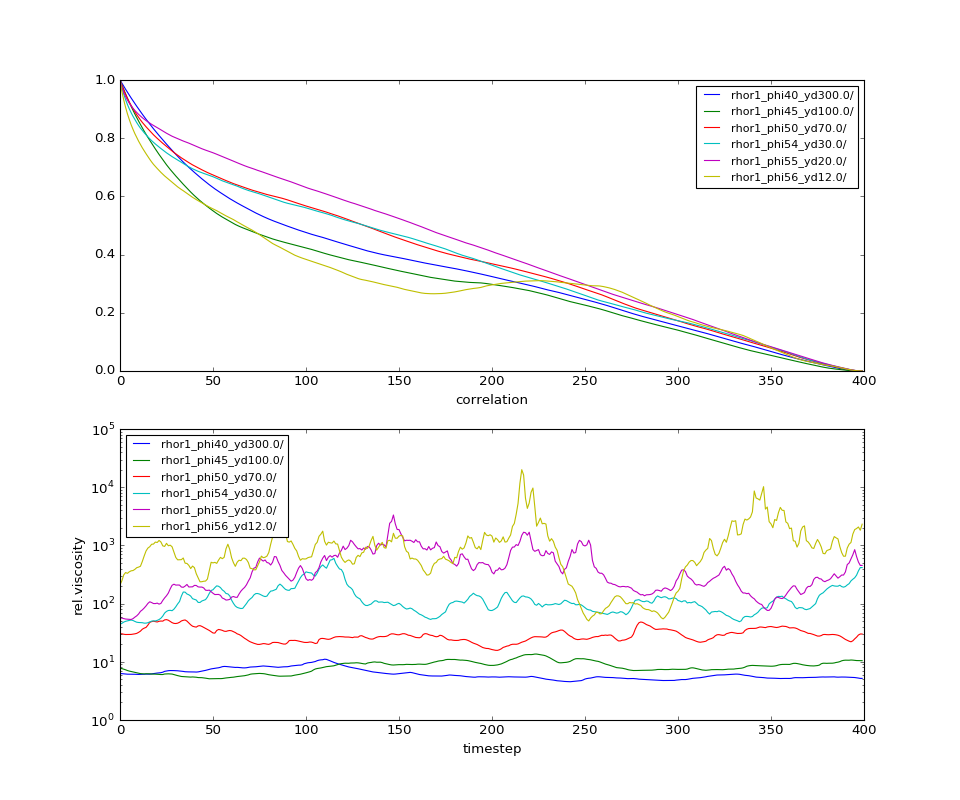

In [69]:
# paths_input = ["rhor1_phi56_yd{}/".format(float(y)) for y in np.arange(1,1001,step=1)]
# paths_input = ["rhor1_phi56_yd{}/".format(float(y)) for y in [10.0,12.0,100.0]]
# paths_input = ["rhor1_phi50_yd{}/".format(float(y)) for y in [20,30,50,70,100]]
paths_input = "rhor1_phi40_yd{0}/,rhor1_phi45_yd{1}/,rhor1_phi50_yd{2}/,rhor1_phi54_yd{3}/,rhor1_phi55_yd{4}/,rhor1_phi56_yd{5}/"\
.format(300.0,100.0,70.0,30.0,20.0,12.0).split(',')
print paths_input
plot_acf_temporal(paths_input=paths_input)


{'autocorr_not_normalized': <function autocorr_not_normalized at 0x2aab1f3932a8>, 'autocorr_fft': <function autocorr_fft at 0x2aab1f476e60>, 'autocorr_normalized': <function autocorr_normalized at 0x2aab1f834a28>}
['rhor1_phi40_yd300.0/', 'rhor1_phi45_yd100.0/', 'rhor1_phi50_yd70.0/', 'rhor1_phi54_yd30.0/', 'rhor1_phi55_yd20.0/', 'rhor1_phi56_yd12.0/']
rhor1_phi40_yd300.0/  available timesteps:1004
rhor1_phi45_yd100.0/  available timesteps:1002
rhor1_phi50_yd70.0/  available timesteps:1001
rhor1_phi54_yd30.0/  available timesteps:562
rhor1_phi55_yd20.0/  available timesteps:1002
rhor1_phi56_yd12.0/  available timesteps:902
<function autocorr_not_normalized at 0x2aab1f3932a8>
<function autocorr_not_normalized at 0x2aab1f3932a8>
<function autocorr_not_normalized at 0x2aab1f3932a8>
<function autocorr_not_normalized at 0x2aab1f3932a8>
<function autocorr_not_normalized at 0x2aab1f3932a8>
<function autocorr_not_normalized at 0x2aab1f3932a8>


rhor1_phi56_yd12.0/: 100%|##########| 500/500 [00:41<00:00, 12.07it/s]


<IPython.core.display.Javascript object>


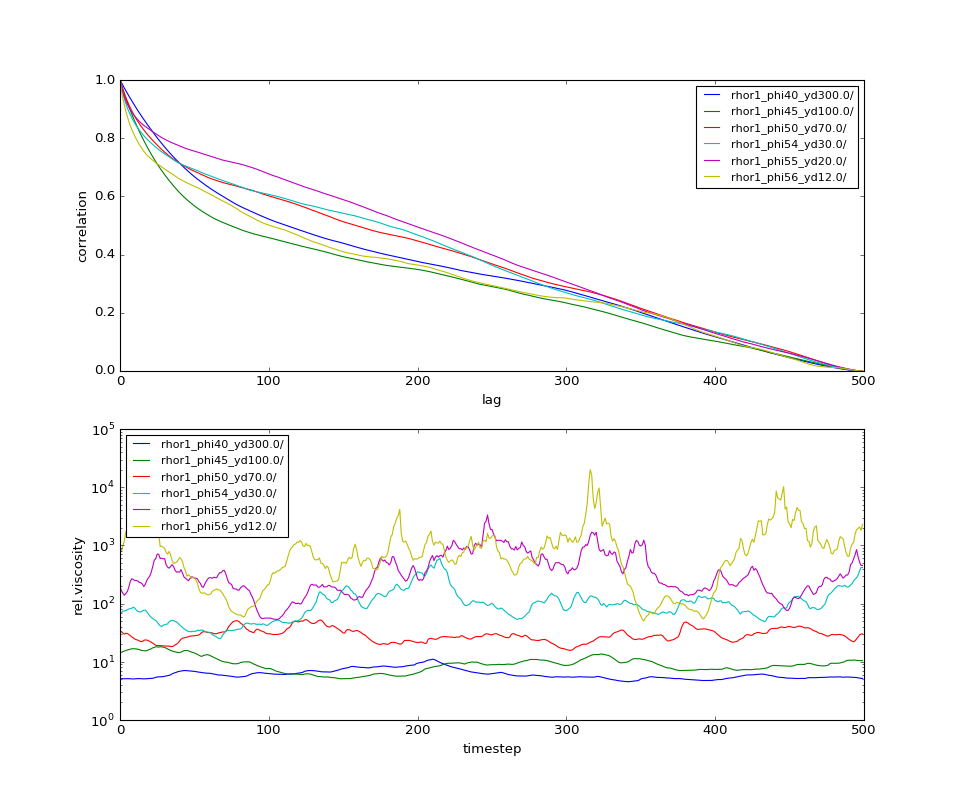

rhor1_phi40_yd300.0/  available timesteps:1004
rhor1_phi45_yd100.0/  available timesteps:1002
rhor1_phi50_yd70.0/  available timesteps:1001
rhor1_phi54_yd30.0/  available timesteps:562
rhor1_phi55_yd20.0/  available timesteps:1002
rhor1_phi56_yd12.0/  available timesteps:902
<function autocorr_normalized at 0x2aab1f834a28>
<function autocorr_normalized at 0x2aab1f834a28>
<function autocorr_normalized at 0x2aab1f834a28>
<function autocorr_normalized at 0x2aab1f834a28>
<function autocorr_normalized at 0x2aab1f834a28>
<function autocorr_normalized at 0x2aab1f834a28>


rhor1_phi56_yd12.0/: 100%|##########| 500/500 [00:41<00:00, 11.94it/s]


<IPython.core.display.Javascript object>


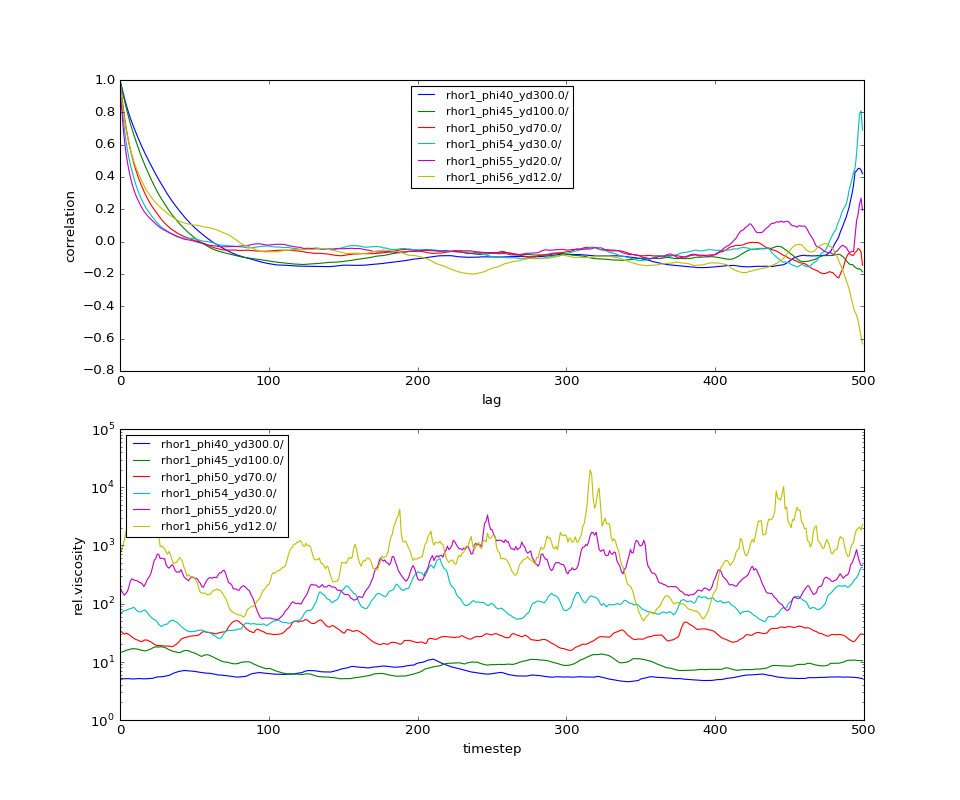

rhor1_phi40_yd300.0/  available timesteps:1004
rhor1_phi45_yd100.0/  available timesteps:1002
rhor1_phi50_yd70.0/  available timesteps:1001
rhor1_phi54_yd30.0/  available timesteps:562
rhor1_phi55_yd20.0/  available timesteps:1002
rhor1_phi56_yd12.0/  available timesteps:902
<function autocorr_fft at 0x2aab1f476e60>
<function autocorr_fft at 0x2aab1f476e60>
<function autocorr_fft at 0x2aab1f476e60>
<function autocorr_fft at 0x2aab1f476e60>
<function autocorr_fft at 0x2aab1f476e60>
<function autocorr_fft at 0x2aab1f476e60>


rhor1_phi56_yd12.0/: 100%|##########| 500/500 [00:40<00:00, 15.21it/s]


<IPython.core.display.Javascript object>


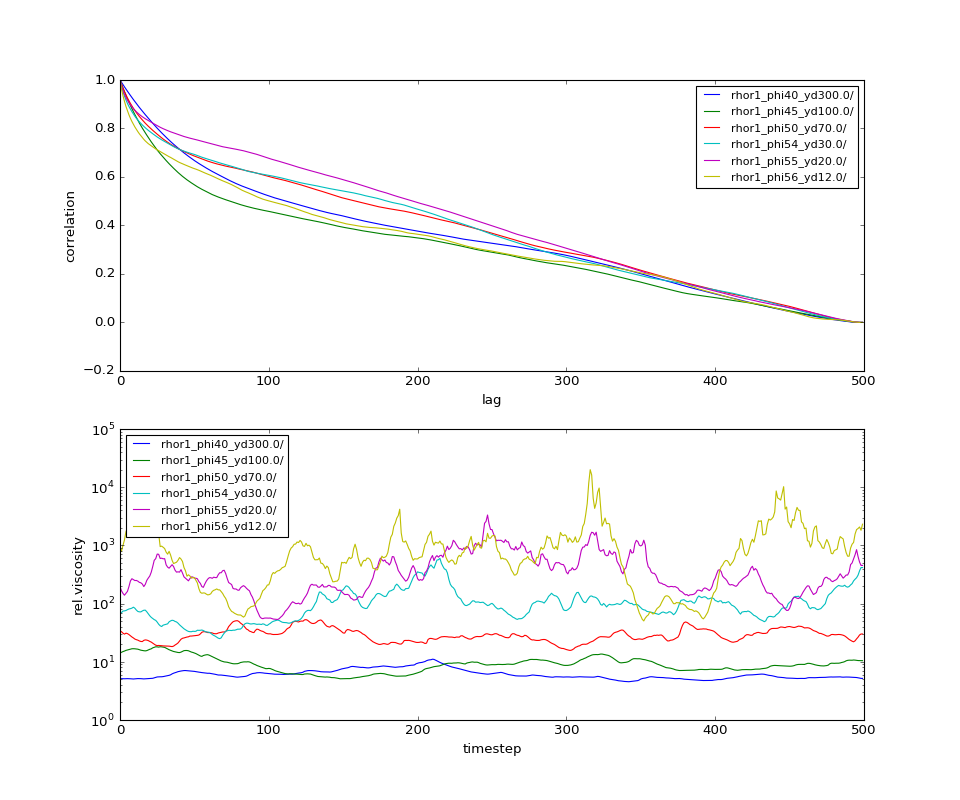

In [70]:
# class autocorrelations():
#     def __init__(self,correl_type):
#         self.correl_type = correl_type
#     def calc_correlation(self):
#         """
#         correl_type==1 --> division by variance smaple size as per http://stackoverflow.com/q/14297012/190597
#         correl_type==2 --> correlation as per np.correlate similr to 1
#         correl_type==3 --> correlation as per signal.fftconvolve
#         correl_type==4 --> correlation as per np.correlate similr to 1, not normalized
#         """
#         if self.correl_type==1:
#             print "correl_type=1 --> division by variance smaple size as per http://stackoverflow.com/q/14297012/190597"
#             return estimated_autocorrelation
#         elif self.correl_type==2:
#             print "correl_type=2 --> correlation as per np.correlate similr to 1"
#             return autocorr
#         elif self.correl_type==3:
#             print "correl_type=3 --> correlation as per signal.fftconvolve"
#             return autocorr_fft
#         elif self.correl_type==4: 
#             print "correl_type=4 --> correlation as per np.correlate similr to 1, not normalized"
#             return autocorr_2
#         else: 
#             print "enter valid type"
def autocorr_normalized(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')
    r = r[-n:]
    #assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    if np.isnan(np.min(result))  : result = np.nan_to_num(result)
    return result

def autocorr_not_normalized(x):
    corrs2 = np.correlate(x, x, mode='full')
    if np.isnan(np.min(corrs2))  : result = np.nan_to_num(corrs2)
    return corrs2[corrs2.size//2:]

def autocorr_fft(sig):
    result = signal.fftconvolve(sig, sig[::-1], mode='full')
    result = result[result.size//2:]
#     return np.arange(-len(sig)+1,len(sig)), autocorr
    return result

dispatcher={}
for func in [autocorr_normalized,autocorr_not_normalized,autocorr_fft]:
    dispatcher[func.__name__] = func
print dispatcher

# tmin = -10
def calc_stuff(path,tmin,correltype):
    try:
        correltype=dispatcher[correltype]
    except KeyError:
        raise ValueError('enter one of '+str(dispatcher.keys()))
    print correltype
    try:
        dataset = sp.reader.DataSet(path,particles=True, fluid=False)
        timeseries = dataset.tlist[tmin:] 
        friction_timeseries = np.zeros((len(timeseries),dataset.npart))
        for i,t in enumerate(tqdm(timeseries,ascii=True,desc=path)):
            dataset.load_state(dataset.tlist[i])
            fric_on_particle = [0 if j == 0 else 1 for j in map(np.linalg.norm, dataset.particles.force_fric)]
            friction_timeseries[i] = fric_on_particle
        friction_timeseries = friction_timeseries.T
#         correl = autocorrelations(correltype).calc_correlation() #use different correlation types
        correl = correltype
        corrs = map(np.mean, np.transpose(map(correl, friction_timeseries)))
        corrs = np.asarray(corrs)/float(max(corrs))
        return corrs
    except Exception as e:
        print e
        return [0,0]
# 1 if fric > mean fric, else 0 
def calc_stuff2(path,correltype): 
    print correltype
    try:
        dataset = sp.reader.DataSet(path,particles=True, fluid=False)
        timeseries = dataset.tlist[tmin:] 
        friction_timeseries = np.zeros((len(timeseries),dataset.npart))
        for i,t in enumerate(tqdm(timeseries,ascii=True,desc=path)):
            dataset.load_state(dataset.tlist[i])
            fric_on_particle = [j for j in map(np.linalg.norm, dataset.particles.force_fric)]
            friction_timeseries[i] = fric_on_particle
        friction_timeseries = friction_timeseries.T
        max_fric = [max(i) for i in friction_timeseries]
        friction_timeseries_modified = np.zeros_like(friction_timeseries)
#         print np.shape(friction_timeseries)
        for i in range(np.shape(friction_timeseries)[0]):
            mean_i = np.mean(friction_timeseries[i])
            for j in range(np.shape(friction_timeseries)[1]):
                if friction_timeseries[i][j] > mean_i:
                    friction_timeseries_modified[i][j] = 1
        friction_timeseries = friction_timeseries_modified
#         print friction_timeseries
#         correl = autocorrelations(correltype).calc_correlation() #use different correlation types
        correl = correltype
        corrs = map(np.mean, np.transpose(map(correl, friction_timeseries)))
        corrs = np.asarray(corrs)/float(max(corrs))
        return corrs
    except Exception as e:
        print e
        return [0,0]
        

def plot_acf_temporal(paths_input,tmin,correltype):
    paths = []
    for i in paths_input: 
        if os.path.exists(i):
            try:
                dataset = sp.reader.DataSet(i,particles=True, fluid=False)
                print i, " available timesteps:" + str(len(dataset.tlist))
                if len(dataset.tlist)>120: 
                    paths.append(i)
            except: 
                continue
    try:
        pool = multiprocessing.Pool(len(paths))
#         corrs_list = pool.map(calc_stuff, paths)
        corrs_list = pool.map(partial(calc_stuff,tmin=tmin,correltype=correltype), paths)

    finally:
        pool.close()
        pool.join()
    plt.figure(figsize=[12,10]) 
    plt.subplot(211)
    for i in range(len(paths)):
        if os.path.exists(paths[i]):
            plt.plot(corrs_list[i],label=paths[i])
    plt.legend(loc="best",fontsize=10)
    plt.xlabel("lag")
    plt.ylabel("correlation")
    
    plt.subplot(212)
    for path in paths_input:
        if os.path.exists(path+"result/nu_t.dat"):
            try:
                dataset = sp.reader.DataSet(path,particles=True, fluid=False)
                if len(dataset.tlist)>120:
                    nu_file = pd.read_csv(path+"result/nu_t.dat")
                    nu_vals = nu_file[nu_file.columns[4]][tmin:]
                    plt.plot(range(len(nu_vals)),nu_vals, label=path)
                    plt.xlabel("timestep")
                    plt.ylabel("rel.viscosity")
            except:
                continue
    plt.legend(loc='best',fontsize=10)
    plt.yscale("log")
#         plt.title("autocorrelation type: {}".format(correltype.__name__))
    plt.show()
paths_input = "rhor1_phi40_yd{0}/,rhor1_phi45_yd{1}/,rhor1_phi50_yd{2}/,rhor1_phi54_yd{3}/,rhor1_phi55_yd{4}/,rhor1_phi56_yd{5}/"\
.format(300.0,100.0,70.0,30.0,20.0,12.0).split(',')
print paths_input
plot_acf_temporal(paths_input=paths_input,tmin=-500,correltype ='autocorr_not_normalized')
plot_acf_temporal(paths_input=paths_input,tmin=-500,correltype ='autocorr_normalized')
plot_acf_temporal(paths_input=paths_input,tmin=-500,correltype ='autocorr_fft')
